# Introduction

This is Single-Cell RNA-Sequencing data from Mouse Incisor reveals dental epithelial cell-type specific genes. Dental epithelial stem cells are ancestors to four types of dental epithelial cells: inner enamel epithelium (IEE), outer enamel epithelium (OEE), stratum intermedium (SI), and stellate reticulum (SR). IEE cells further differentiate into enamel-forming ameloblasts, which play distinct roles, and are essential for enamel formation.

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
from matplotlib.pyplot import rc_context
import seaborn as sns


#### selected dataset - Single-Cell RNA-Sequencing From Mouse Incisor Reveals Dental Epithelial Cell-Type Specific Genes

In [2]:
input_file = 'data/GSM4407907/'
adata = sc.read_10x_mtx(
    input_file,  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)                              # write a cache file for faster subsequent reading

### filtering

In [3]:
adata

AnnData object with n_obs × n_vars = 6260 × 48816
    var: 'gene_ids'

In [4]:
sc.pp.filter_cells(adata, min_genes=10)
sc.pp.filter_genes(adata, min_cells=10)

In [5]:
adata

AnnData object with n_obs × n_vars = 6260 × 18021
    obs: 'n_genes'
    var: 'gene_ids', 'n_cells'

In [6]:
adata.var['mt'] = adata.var_names.str.startswith('mt')  # annotate the group of mitochondrial genes as 'mt'
adata.var['mt'].value_counts()

False    17996
True        25
Name: mt, dtype: int64

In [7]:
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=True, inplace=True)

In [8]:
adata.obs.head()

,n_genes,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,total_counts_mt,log1p_total_counts_mt,pct_counts_mt
AAACCTGAGAACAACT-1,2236,2236,7.712891,8947.0,9.099185,132.0,4.890349,1.475355
AAACCTGAGAGCCCAA-1,2176,2171,7.683404,6267.0,8.743213,145.0,4.983607,2.313707
AAACCTGAGAGCTTCT-1,2208,2206,7.699389,7995.0,8.986696,126.0,4.844187,1.575985
AAACCTGAGGCGCTCT-1,5380,5374,8.589514,32952.0,10.402838,485.0,6.186209,1.471838
AAACCTGAGTCTTGCA-1,2041,2039,7.620705,7148.0,8.874728,144.0,4.976734,2.014549


In [9]:
adata.var.head()

,gene_ids,n_cells,mt,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts
Xkr4,ENSMUSG00000051951.5,11,False,11,0.001757,0.001756,99.824281,11.0,2.484907
Gm37180,ENSMUSG00000103377.1,24,False,24,0.003834,0.003827,99.616613,24.0,3.218876
Gm37363,ENSMUSG00000104017.1,24,False,24,0.003834,0.003827,99.616613,24.0,3.218876
Gm37686,ENSMUSG00000103025.1,11,False,11,0.001757,0.001756,99.824281,11.0,2.484907
Gm38148,ENSMUSG00000103161.1,23,False,23,0.003674,0.003667,99.632588,23.0,3.178054


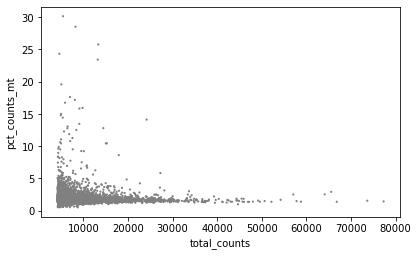

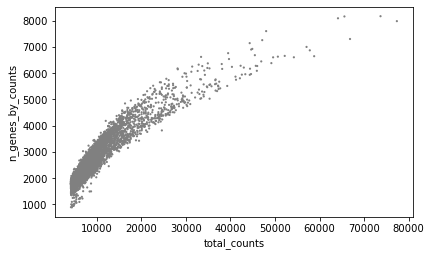

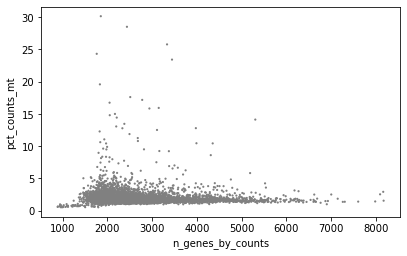

In [10]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')
sc.pl.scatter(adata, x='n_genes_by_counts', y='pct_counts_mt')

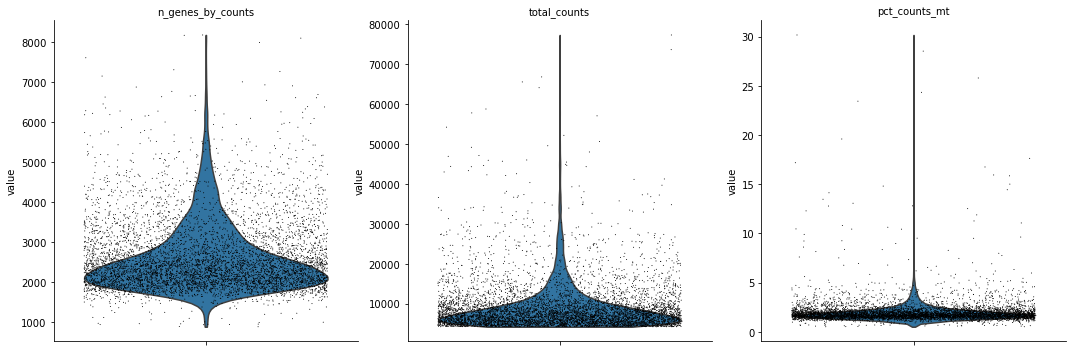

In [11]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

In [12]:
adata = adata[adata.obs.n_genes_by_counts > 1500, :].copy() # filter out 1500
adata = adata[adata.obs.pct_counts_mt < 5, :].copy()

adata

AnnData object with n_obs × n_vars = 6112 × 18021
    obs: 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

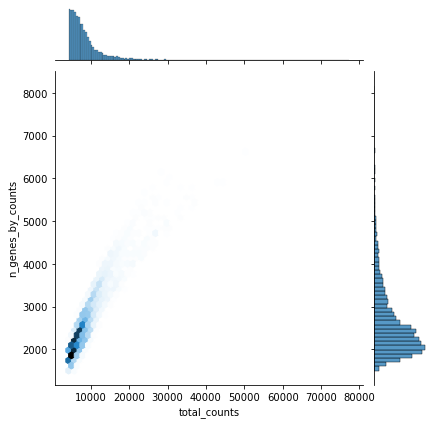

In [13]:
sns.jointplot(
    data=adata.obs,
    x="total_counts",
    y="n_genes_by_counts",
    kind="hex",
)

### Normalization

In [14]:
sc.pp.normalize_total(adata, target_sum=1e4) # Total-count normalize (library-size correct) the data matrix X to 10,000 reads per cell, so that counts become comparable among cells.
sc.pp.log1p(adata) # log-normalization

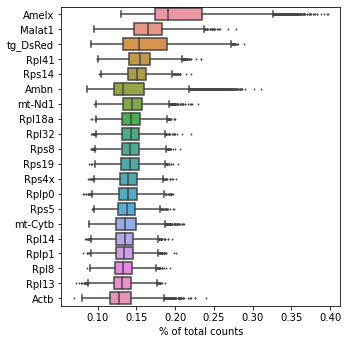

In [15]:
sc.pl.highest_expr_genes(adata, n_top=20, )

### Identification of highly variable features

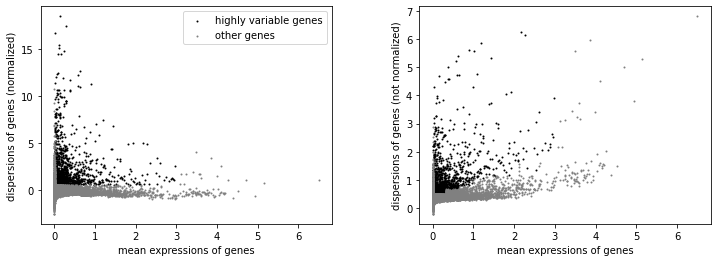

In [16]:
import matplotlib.pyplot as plt
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
gca = sc.pl.highly_variable_genes(adata, show=False, log=False) # can not scale only x


In [17]:
adata.var['highly_variable'].value_counts()

False    16457
True      1564
Name: highly_variable, dtype: int64

### PCA

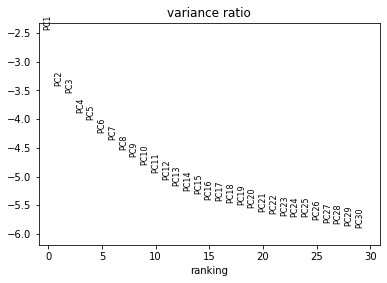

In [18]:
sc.tl.pca(adata, svd_solver='arpack', n_comps=30)
sc.pl.pca_variance_ratio(adata, log=True)

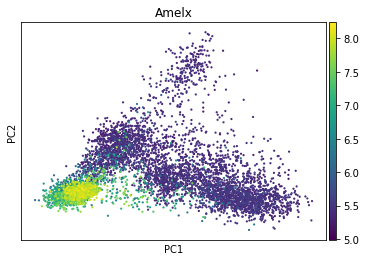

In [19]:
sc.pl.pca(adata, color='Amelx')

### UMAP 
(had to uninstall "umap" and reinstall "umap-learn" and "numba" of specific versions to make plots below work

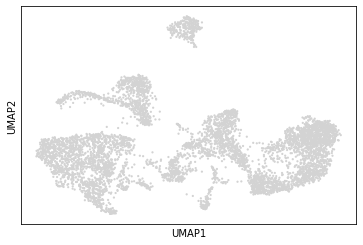

In [20]:
sc.pp.neighbors(adata, n_neighbors=30, n_pcs=30)
sc.tl.umap(adata)
sc.pl.umap(adata)

### Cell clusters
louvain package was needed to be installed

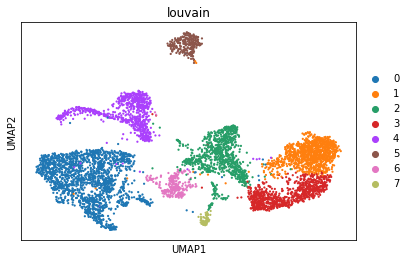

In [29]:
sc.tl.louvain(adata, resolution=0.4) 
# adjusted resolution for a best match 
# to a visual representation of clusters
sc.pl.umap(adata, color='louvain')

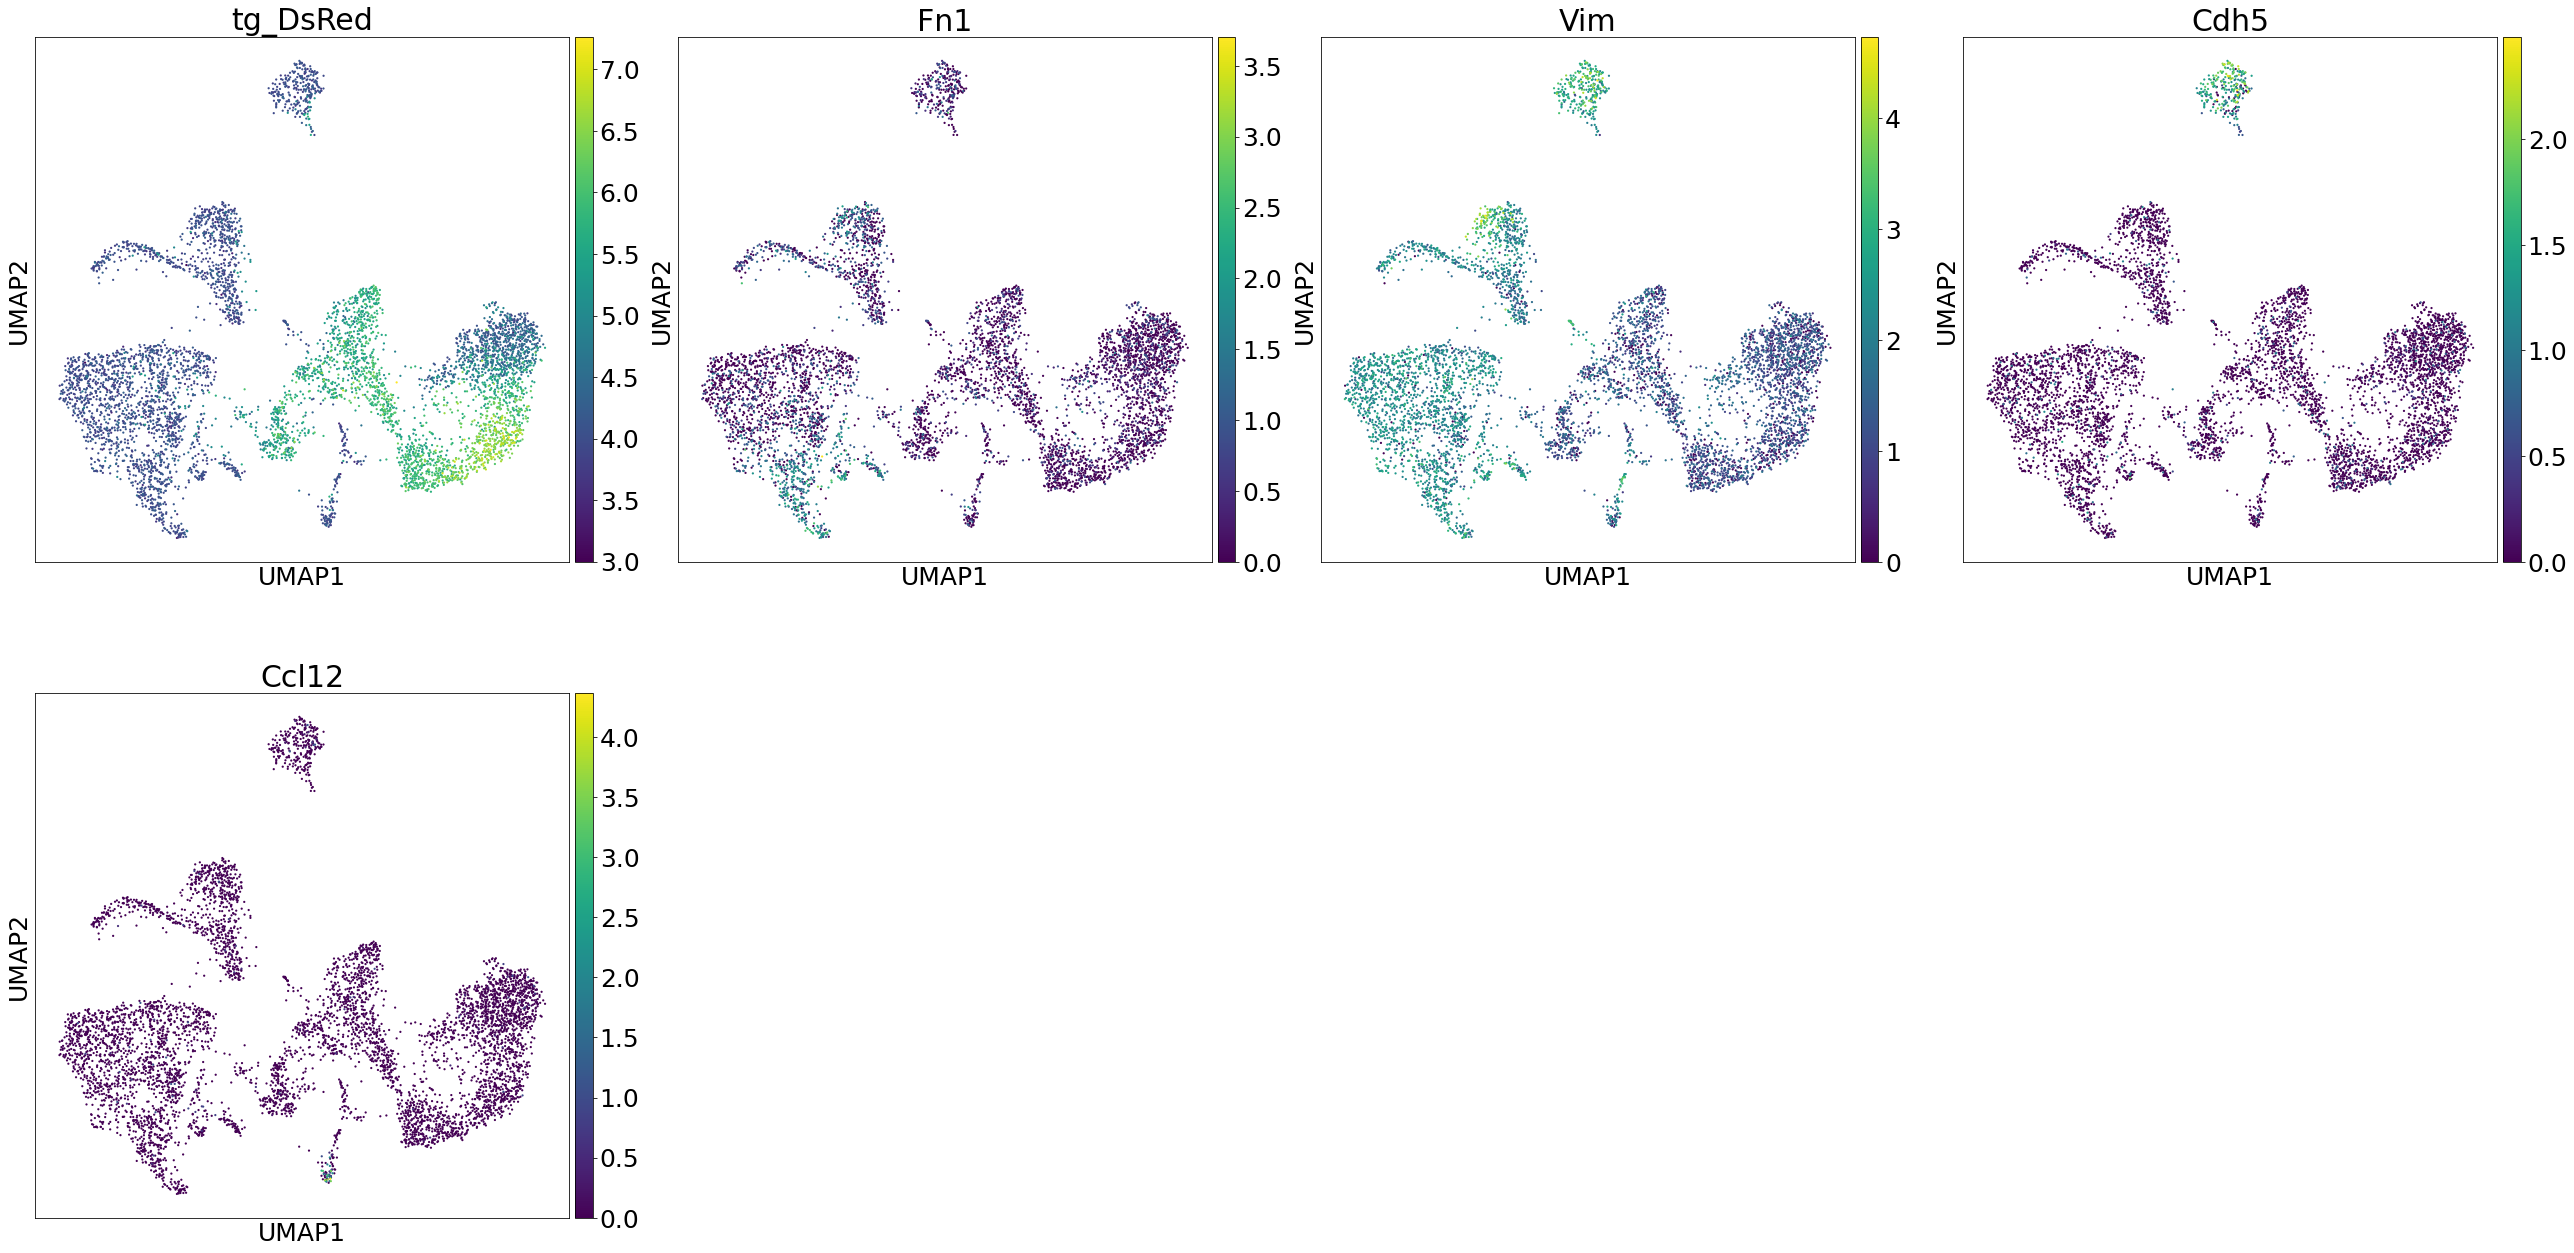

In [43]:
with rc_context({'figure.figsize': (10, 10), 'font.size': 25.0}):
    sc.pl.umap(adata, color=["tg_DsRed", "Fn1", "Vim", 'Cdh5', 'Ccl12'])

### DGE tests to find cluster markers

In [34]:
sc.tl.rank_genes_groups(adata, 'louvain', method='wilcoxon')
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(1)


,0,1,2,3,4,5,6,7
0,Col3a1,Ambn,Ptma,Fxyd3,Lum,Egfl7,Chchd10,Fcer1g


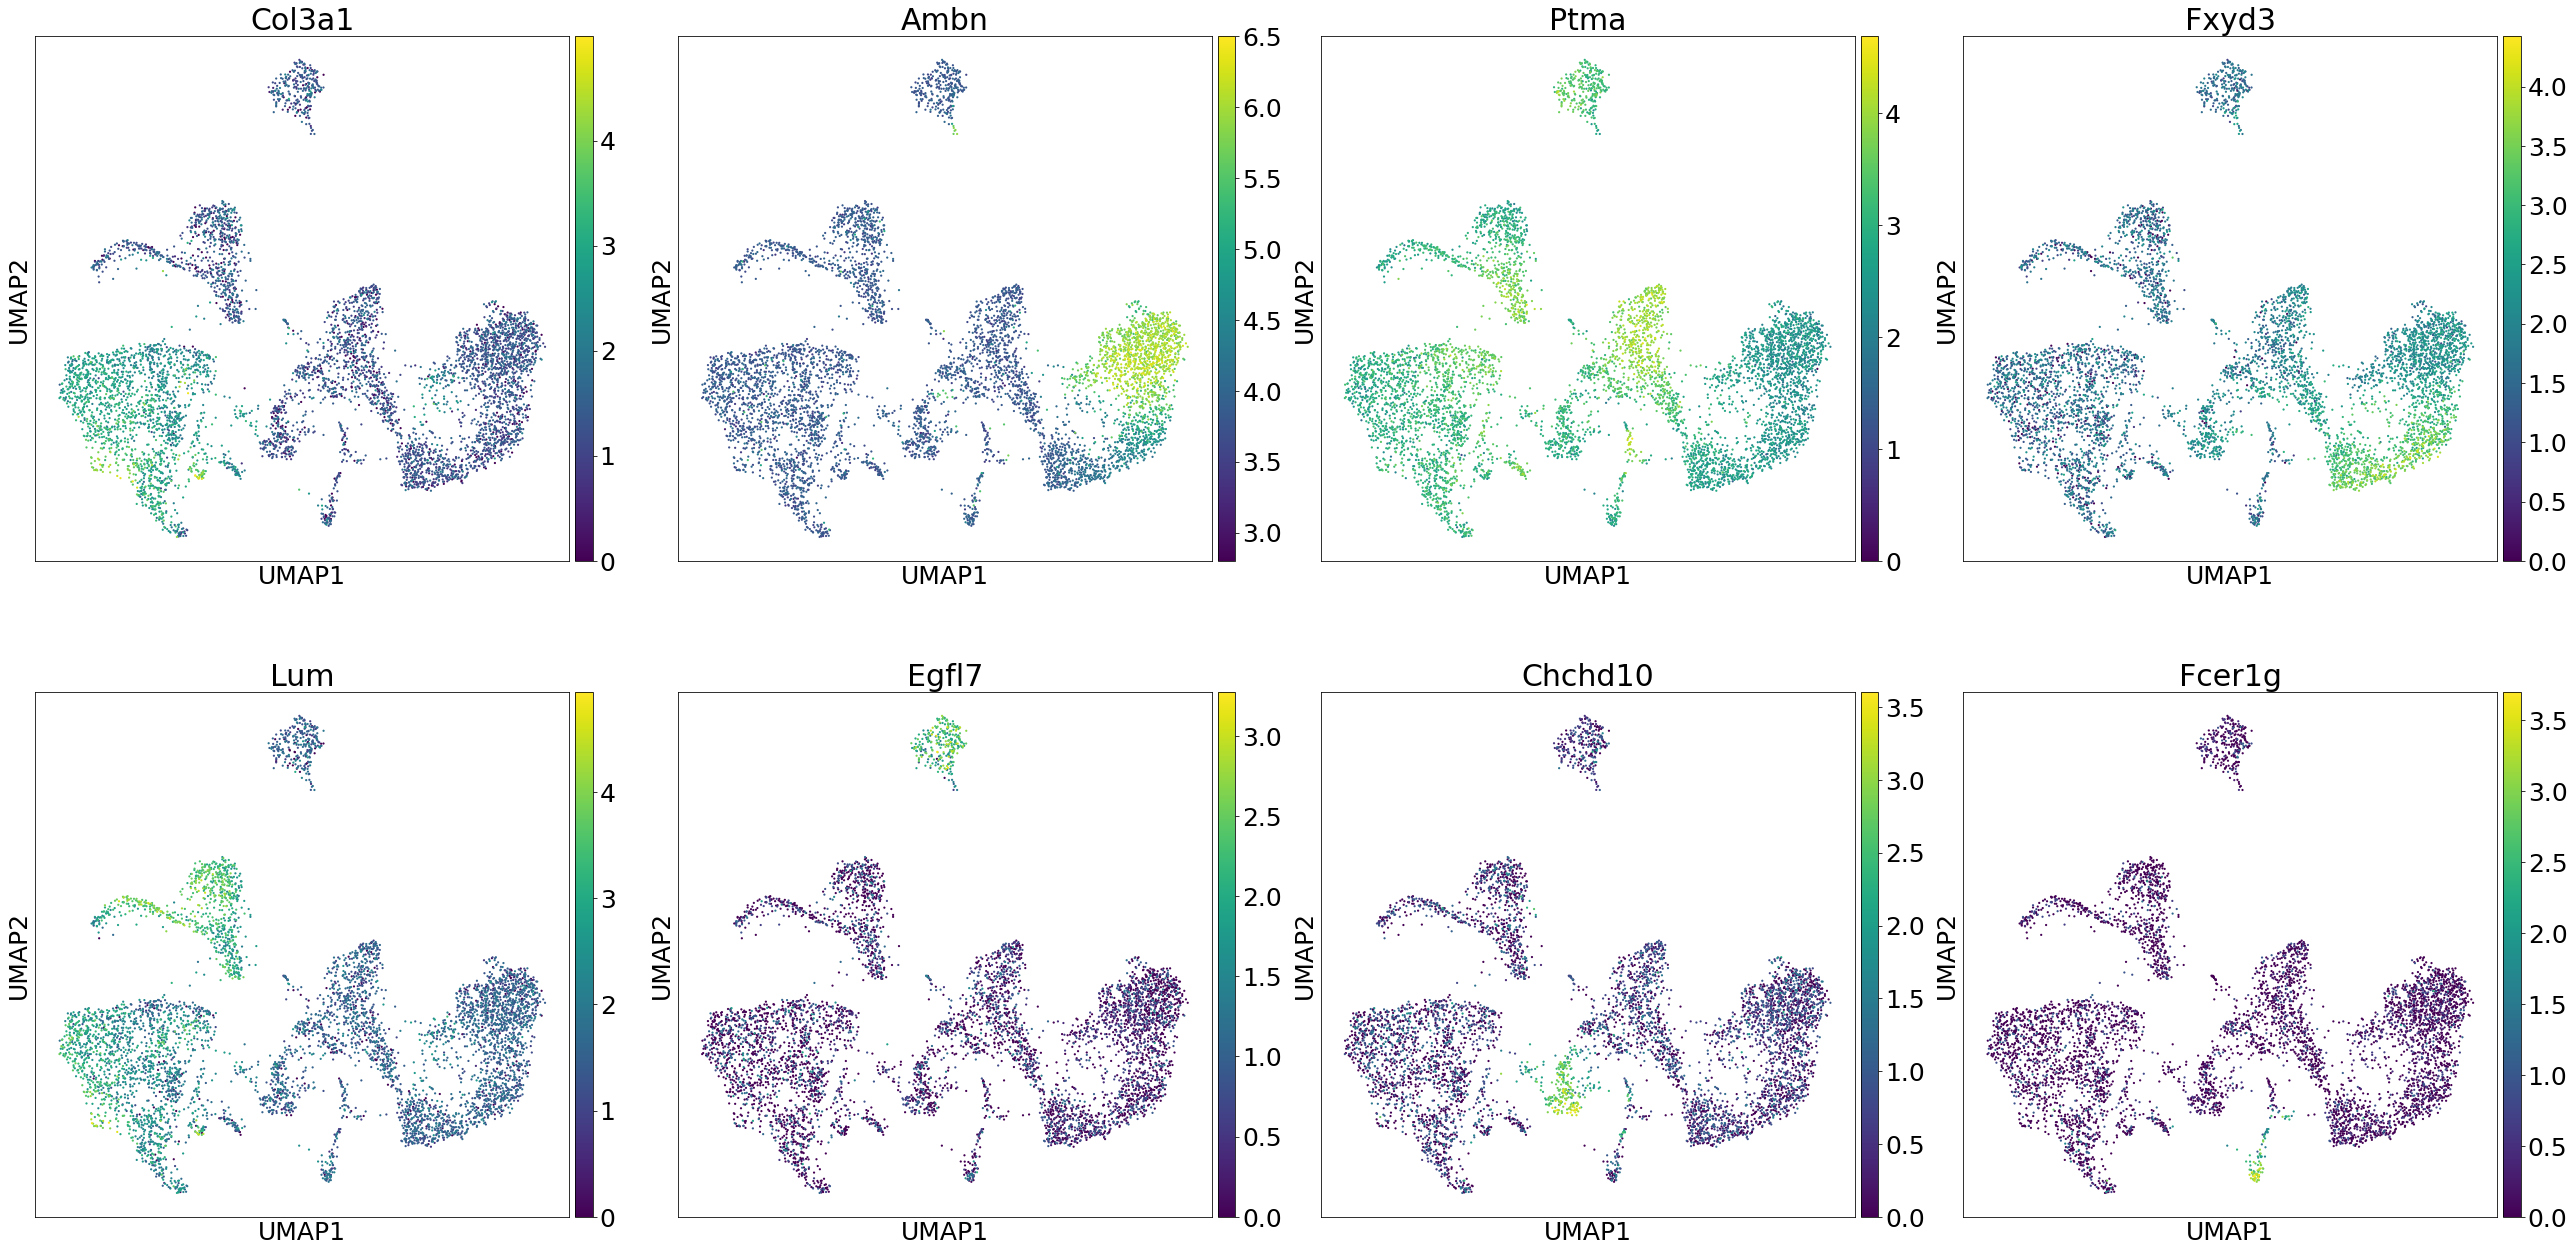

In [44]:
with rc_context({'figure.figsize': (10, 10), 'font.size': 25.0}):
    sc.pl.umap(adata, color=pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(1).iloc[0].values)

We can see, that for same resolution, the number of clusters differs

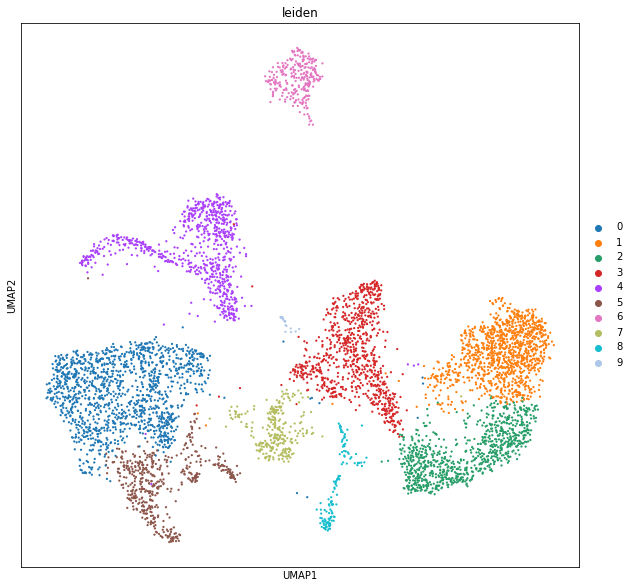

In [45]:
with rc_context({'figure.figsize': (10, 10)}):
    sc.tl.leiden(adata, resolution=0.4)
    sc.pl.umap(adata, color='leiden', s=20)

### Conclusion

Comparing with the previous R report on this exact dataset, there is a single intersection for markers, while number of clusters remained the same. There are also no common markers with paper (however, r-pipeline also resulted in a low number of intertecting markers). This could probably be explained to some degree by the different output shapes after filtering (not exactly sure why it differs, pipeline looks the same) 